In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Step 1: Load Data
transactions_df = pd.read_csv("Transactions.csv")
customers_df = pd.read_csv("Customers.csv")

In [5]:
# Convert date columns to datetime
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])

In [6]:
# Step 2: Aggregate transaction data
customer_transactions = transactions_df.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count")
).reset_index()

In [7]:
# Merge with customer profile data
customer_data = pd.merge(customers_df, customer_transactions, on="CustomerID", how="left")
customer_data.fillna(0, inplace=True)  # Fill missing transaction data with 0


In [8]:
# Step 3: Encode categorical variables
encoder = OneHotEncoder(sparse=False, drop="first")
region_encoded = encoder.fit_transform(customer_data[["Region"]])
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(["Region"]))

In [9]:
# Combine features
features = pd.concat([
    customer_data[["total_spent", "transaction_count"]],
    region_encoded_df
], axis=1)

In [10]:
# Step 4: Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

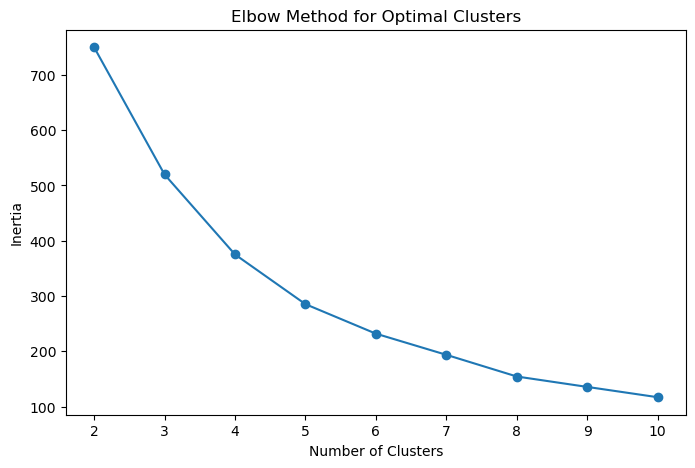

In [11]:
# Step 5: Determine optimal number of clusters (Elbow Method)
inertia = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Clusters")
plt.show()

In [12]:
# Step 6: Apply KMeans Clustering
optimal_clusters = 4  # Replace with the optimal number from the Elbow Method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(scaled_features)
customer_data['Cluster'] = kmeans.labels_

In [13]:
# Step 7: Evaluate Clustering
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

Davies-Bouldin Index: 1.0142
Silhouette Score: 0.4116


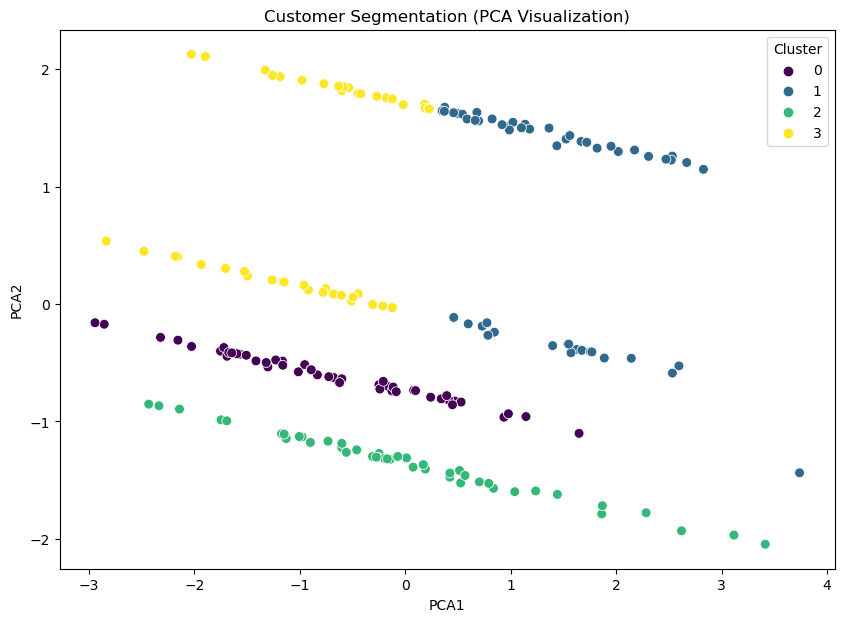

In [14]:
# Step 8: Visualize Clusters using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
customer_data['PCA1'] = reduced_features[:, 0]
customer_data['PCA2'] = reduced_features[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Cluster", data=customer_data, palette="viridis", s=50
)
plt.title("Customer Segmentation (PCA Visualization)")
plt.show()

In [16]:
# Step 9: Save Results
customer_data.to_csv("Clustering_result.csv", index=False)